# Overcoming Presentation Bias

In this code, we use a gaussian process and bayesian optimization, to explore the corpus for a query. We seek out documents that might give our click model information it doesn't yet have given a set of features that describe the documents.

In [1]:
! cd ../data/retrotech && head signals.csv

import random
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from aips import *
from session_gen import SessionGenerator
import os
from IPython.core.display import display,HTML

import matplotlib.pyplot as plt
import numpy as np
# if using a Jupyter notebook, includue:
%matplotlib inline

"query_id","user","type","target","signal_time"
"u2_0_1","u2","query","nook","2019-07-31 08:49:07.3116"
"u2_1_2","u2","query","rca","2020-05-04 08:28:21.1848"
"u3_0_1","u3","query","macbook","2019-12-22 00:07:07.0152"
"u4_0_1","u4","query","Tv antenna","2019-08-22 23:45:54.1030"
"u5_0_1","u5","query","AC power cord","2019-10-20 08:27:00.1600"
"u6_0_1","u6","query","Watch The Throne","2019-09-18 11:59:53.7470"
"u7_0_1","u7","query","Camcorder","2020-02-25 13:02:29.3089"
"u9_0_1","u9","query","wireless headphones","2020-04-26 04:26:09.7198"
"u10_0_1","u10","query","Xbox","2019-09-13 16:26:12.0132"


In [2]:
def all_sessions():
    import glob
    sessions = pd.concat([pd.read_csv(f, compression='gzip')
                          for f in glob.glob('*_sessions.gz')])
    return sessions.rename(columns={'clicked_doc_id': 'doc_id'})
    
sessions = all_sessions()
sessions

,sess_id,query,rank,doc_id,clicked
0,2,dryer,0.0,12505451713,False
1,2,dryer,1.0,84691226727,True
2,2,dryer,2.0,883049066905,False
3,2,dryer,3.0,14381196320,False
4,2,dryer,4.0,74108056764,False
...,...,...,...,...,...
149995,55001,blue ray,25.0,22265004517,False
149996,55001,blue ray,26.0,885170038875,False
149997,55001,blue ray,27.0,786936817232,False
149998,55001,blue ray,28.0,600603132872,False


In [3]:
products = fetch_products(doc_ids=sessions['doc_id'].unique())

products

,image,upc,name,manufacturer,shortDescription,longDescription,id,_version_
0,"<img height=""100"" src=""../data/retrotech/image...",24543750949,X-Men: First Class - Widescreen Dubbed Subtitl...,\N,\N,\N,13b0b350-8832-46df-9aea-a8991af6534b,1684550853664440322
1,"<img height=""100"" src=""../data/retrotech/image...",803238004525,Headphones - CD,Suicide Squeeze,\N,\N,c2490d46-dd98-4b55-a594-1e064893d3dd,1684550853904564231
2,"<img height=""100"" src=""../data/retrotech/image...",883393003458,"RCA - 46"" Class - LCD - 1080p - 60Hz - HDTV",RCA,\N,This HDTV showcases stunning images up to 1080...,953d1c22-88d7-4009-a5f6-b0783a411a11,1684550854019907593
3,"<img height=""100"" src=""../data/retrotech/image...",843404064434,ZAGG - InvisibleSHIELD for Apple&#xAE; iPhone&...,ZAGG,Compatible with Apple&#xAE; iPhone&#xAE; 4; mi...,Protect your Apple iPhone 4's screen with this...,8355f53e-da62-4667-a86e-9fca0f927ad4,1684550854146785281
4,"<img height=""100"" src=""../data/retrotech/image...",600603135101,Rocketfish&#x2122; - Protective Cover for NOOK,Rocketfish&#x99;,Compatible with NOOK WiFi and NOOK 3G+WiFi; th...,Protect your NOOK eReader from bumps and scrat...,7346a389-ef33-448e-b7e8-45208226d43b,1684550854148882432
...,...,...,...,...,...,...,...,...
307,"<img height=""100"" src=""../data/retrotech/image...",97361455044,Thor (2011) (2 Disc) (W/Dvd) - Widescreen Dubb...,\N,\N,\N,1d19f238-5eac-4884-8866-b1cd84a2199c,1684550857352282117
308,"<img height=""100"" src=""../data/retrotech/image...",786936817232,Pirates Of The Caribbean: On Stranger Tides (2...,\N,\N,\N,fc0243b3-74aa-4625-aea3-8f62374046e8,1684550857360670725
309,"<img height=""100"" src=""../data/retrotech/image...",786936817218,Pirates Of The Caribbean: On Stranger Tides (3...,\N,\N,\N,94ac7204-2099-472c-b2ab-d75ec63cb613,1684550857360670727
310,"<img height=""100"" src=""../data/retrotech/image...",24543742180,Star Wars: The Complete Saga [9 Discs / Blu-ra...,\N,\N,\N,83071377-bcd3-44c3-a990-55aafeea01a2,1684550857673146372


In [286]:
QUERY='dryer'
sdbn_sessions = sessions[sessions['query'] == QUERY].copy().set_index('sess_id')

last_click_per_session = sdbn_sessions.groupby(['clicked', 'sess_id'])['rank'].max()[True]

sdbn_sessions['last_click_rank'] = last_click_per_session
sdbn_sessions['examined'] = sdbn_sessions['rank'] <= sdbn_sessions['last_click_rank']

sdbn = sdbn_sessions[sdbn_sessions['examined']].groupby('doc_id')[['clicked', 'examined']].sum()
sdbn['grade'] = sdbn['clicked'] / sdbn['examined']

sdbn = sdbn.sort_values('grade', ascending=False)

PRIOR_GRADE=0.3
PRIOR_WEIGHT=100
sdbn['prior_a'] = PRIOR_GRADE*PRIOR_WEIGHT
sdbn['prior_b'] = (1-PRIOR_GRADE)*PRIOR_WEIGHT

sdbn['posterior_a'] = sdbn['prior_a'] +  sdbn['clicked']
sdbn['posterior_b'] = sdbn['prior_b'] + (sdbn['examined'] - sdbn['clicked'])

sdbn['beta_grade'] = sdbn['posterior_a'] / (sdbn['posterior_a'] + sdbn['posterior_b'])

sdbn.sort_values('beta_grade', ascending=False)

sdbn

,clicked,examined,grade,prior_a,prior_b,posterior_a,posterior_b,beta_grade
doc_id,,,,,,,,
856751002097,133.0,323.0,0.411765,30.0,70.0,163.0,260.0,0.385343
48231011396,166.0,423.0,0.392435,30.0,70.0,196.0,327.0,0.374761
84691226727,804.0,2541.0,0.316411,30.0,70.0,834.0,1807.0,0.315789
74108007469,208.0,708.0,0.293785,30.0,70.0,238.0,570.0,0.294554
12505525766,268.0,974.0,0.275154,30.0,70.0,298.0,776.0,0.277467
36725578241,130.0,477.0,0.272537,30.0,70.0,160.0,417.0,0.277296
48231011402,213.0,818.0,0.260391,30.0,70.0,243.0,675.0,0.264706
12505527456,110.0,428.0,0.257009,30.0,70.0,140.0,388.0,0.265152
74108096487,235.0,1097.0,0.214221,30.0,70.0,265.0,932.0,0.221387


# Listing 11.14

Prepare the sdbn data and compute the variance using the beta distribution formula

In [287]:
sdbn = sdbn[['beta_grade', 'posterior_a', 'posterior_b']].rename(columns={'beta_grade': 'grade', 
                                                                          'posterior_a': 'a', 
                                                                          'posterior_b': 'b'}).copy()

sdbn['beta_variance'] = sdbn['a'] * sdbn['b'] /\
    ((sdbn['a'] + sdbn['b'] + 1) * (sdbn['a'] + sdbn['b'])**2)

sdbn

,grade,a,b,beta_variance
doc_id,,,,
856751002097,0.385343,163.0,260.0,0.000559
48231011396,0.374761,196.0,327.0,0.000447
84691226727,0.315789,834.0,1807.0,0.000082
74108007469,0.294554,238.0,570.0,0.000257
12505525766,0.277467,298.0,776.0,0.000186
36725578241,0.277296,160.0,417.0,0.000347
48231011402,0.264706,243.0,675.0,0.000212
12505527456,0.265152,140.0,388.0,0.000368
74108096487,0.221387,265.0,932.0,0.000144


# Listing 11.15 

Preparing features for Listing 11.14, the output is omitted

In [288]:
# Generate some features (similar to feature logging in chapter 10)

categories = {
    883929085118: 'movie',
    36172950027: 'music',
    12505451713: 'washer dryer accesories',
    883049066905: 'washer dryer accesories',
    74108056764: 'personal health and hygiene',
    77283045400: 'personal health and hygiene',
    14381196320: 'movie',
    783722274422: 'movie',
    665331101927: 'music',
    84691226703: 'washer dryer',
    36725561977: 'washer dryer',
    12505525766: 'washer dryer accesories',
    12505527456: 'washer dryer accesories',
    74108007469: 'personal health and hygiene',
    84691226727: 'washer dryer',
    48231011396: 'washer dryer',
    856751002097: 'washer dryer accesories',
    36725578241: 'washer dryer',
    48231011402: 'washer dryer',
    74108096487: 'personal health and hygiene',
}
categories = pd.Series(categories)

title_term_count = {
    883929085118: 0,
    36172950027: 1,
    12505451713: 1,
    883049066905: 0,
    74108056764: 1,
    77283045400: 1,
    14381196320: 0,
    783722274422: 0,
    665331101927: 0,
    84691226703: 1,
    36725561977: 0,
    12505525766: 1,
    12505527456: 1,
    74108007469: 1,
    84691226727: 1,
    48231011396: 0,
    856751002097: 1,
    36725578241: 1,
    48231011402: 1,
    74108096487: 1,
}
title_term_count = pd.Series(title_term_count)

all_categories = list(set(categories.values)) + ['video games', 'televisions', 'home audio', 'kitchen']

sdbn['categories'] = categories
sdbn['category_index'] = categories.apply(lambda cat: all_categories.index(cat))
sdbn['title_term_count'] = title_term_count

sdbn

,grade,a,b,beta_variance,categories,category_index,title_term_count
doc_id,,,,,,,
856751002097,0.385343,163.0,260.0,0.000559,washer dryer accesories,2,1
48231011396,0.374761,196.0,327.0,0.000447,washer dryer,4,0
84691226727,0.315789,834.0,1807.0,0.000082,washer dryer,4,1
74108007469,0.294554,238.0,570.0,0.000257,personal health and hygiene,3,1
12505525766,0.277467,298.0,776.0,0.000186,washer dryer accesories,2,1
36725578241,0.277296,160.0,417.0,0.000347,washer dryer,4,1
48231011402,0.264706,243.0,675.0,0.000212,washer dryer,4,1
12505527456,0.265152,140.0,388.0,0.000368,washer dryer accesories,2,1
74108096487,0.221387,265.0,932.0,0.000144,personal health and hygiene,3,1


# Listing 11.16

Compute the mean and variance across all observations that share the same feature value

In [289]:
# The beta variance is not the same as the total variance, where there is a population of observations
# corresponding to these features. Many of these have examines / views, others don't. We truly don't know how 
# much any one reduces the variance total
# 100 items

per_unique_feature = sdbn.groupby(['category_index', 'title_term_count'])

mean_grade = per_unique_feature['grade'].mean().to_frame()

grades_diff = per_unique_feature['grade'].max() - per_unique_feature['grade'].min()
mean_grade['variance'] = beta_variance + grades_diff

mean_grade = mean_grade.reset_index()
mean_grade

,category_index,title_term_count,grade,variance
0,0,0,0.207326,0.000113
1,0,1,0.118581,0.000097
2,1,0,0.165950,0.090215
3,2,0,0.141197,0.000054
4,2,1,0.266280,0.249341
5,3,1,0.213391,0.134878
6,4,0,0.298244,0.153738
7,4,1,0.266221,0.109415


,category_index,title_term_count,num_products,prior_a,prior_b,a_scaled,b_scaled,variance,obs_a,obs_b,total_observed,final_a,final_b,ftr_grade,ftr_var
0,0,0,50000,30,70,0.000600,0.001400,0.209581,300.0,1147.0,1.0,0.006600,0.024340,0.213316,0.162776
1,0,1,10,30,70,3.000000,7.000000,0.019091,127.0,944.0,1.0,15.700000,101.400000,0.134073,0.000983
2,1,0,25000,30,70,0.001200,0.002800,0.209163,639.0,2939.0,3.0,0.077880,0.355480,0.179712,0.102846
3,1,1,20,30,70,1.500000,3.500000,0.035000,0.0,0.0,0.0,1.500000,3.500000,0.300000,0.035000
4,2,0,1000,30,70,0.030000,0.070000,0.190909,316.0,1922.0,1.0,0.346000,1.992000,0.147990,0.037774
5,2,1,1200,30,70,0.025000,0.058333,0.193846,986.0,3846.0,4.0,3.311667,12.878333,0.204550,0.009465
6,3,0,51252,30,70,0.000585,0.001366,0.209591,0.0,0.0,0.0,0.000585,0.001366,0.300000,0.209591
7,3,1,50,30,70,0.600000,1.400000,0.070000,1112.0,4509.0,4.0,89.560000,362.120000,0.198282,0.000351
8,4,0,55,30,70,0.545455,1.272727,0.074516,345.0,850.0,2.0,13.090909,32.181818,0.289157,0.004442
9,4,1,60,30,70,0.500000,1.166667,0.078750,1675.0,4576.0,4.0,112.166667,306.233333,0.268085,0.000468


# Listing 11.17 

Training the Gradient Process using the prepared features, the associated grade, and corresponding variance

In [250]:
from sklearn.gaussian_process import GaussianProcessRegressor

y_train = mean['grade']
x_train = mean[['category_index', 'title_term_count']]

gpr=GaussianProcessRegressor(alpha=mean['variance'] )
gpr.fit(x_train, y_train)

GaussianProcessRegressor(alpha=0    0.000113
1    0.000097
2    0.090215
3    0.000054
4    0.249341
5    0.134878
6    0.153738
7    0.109415
Name: variance, dtype: float64,
                         copy_X_train=True, kernel=None, n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)

In [251]:
gpr.predict(np.array([6,1]).reshape(1,-1), return_std=True)

(array([0.03449909]), array([0.9887315]))

# Listing 11.18

Scoring where we might best explore next using "Probability of Improvement"

In [325]:
from scipy.stats import norm

categories_to_explore = list(range(0,10))
title_term_counts_to_explore = list(range(0,3))

index = pd.MultiIndex.from_product([categories_to_explore, title_term_counts_to_explore],
                                   names = ["category", "title_terms"])
explore_options = pd.DataFrame(index=index).reset_index()

predictions_with_std = gpr.predict(explore_options[['category', 'title_terms']], return_std=True)
explore_options['prediction'] = predictions_with_std[0]
explore_options['prediction_stddev'] = predictions_with_std[1]
explore_options['opportunity'] = explore_options['prediction'] - sdbn['grade'].mean()

explore_options['prob_of_improvement'] = norm.cdf( (explore_options['opportunity']) / explore_options['prediction_stddev'])
explore_options.sort_values('prob_of_improvement', ascending=False).head()

,category,title_terms,prediction,prediction_stddev,opportunity,prob_of_improvement
12,4,0,0.269220,0.352777,0.041969,0.547350
13,4,1,0.250365,0.298563,0.023114,0.530854
10,3,1,0.221647,0.318278,-0.005604,0.492976
7,2,1,0.211067,0.399220,-0.016183,0.483832
9,3,0,0.198115,0.513134,-0.029136,0.477360


In [153]:
best_grade

0.38534278959810875

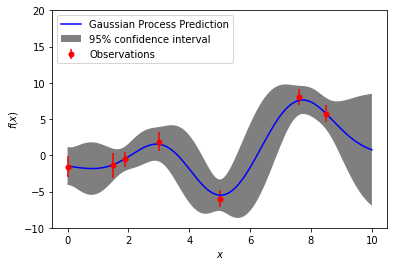

In [119]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x) 

# Noisy Gaussian Process graph, adapted from
# https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html
X = np.array([0,1.5,1.9,3.0,5.0,7.6, 8.5])
X = np.atleast_2d(X).T

# Observations and noise
y = f(X).ravel()
dy = 1 + np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise

# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Gaussian Process Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='black', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

plt.show()

In [106]:
X

array([[0.1       ],
       [0.51052632],
       [0.92105263],
       [1.33157895],
       [1.74210526],
       [2.15263158],
       [2.56315789],
       [2.97368421],
       [3.38421053],
       [3.79473684],
       [4.20526316],
       [4.61578947],
       [5.02631579],
       [5.43684211],
       [5.84736842],
       [6.25789474],
       [6.66842105],
       [7.07894737],
       [7.48947368],
       [7.9       ]])

In [13]:
from scipy.stats import beta
mean, var, skew, kurt = beta.stats(1, 1, moments='mvsk')
var

array(0.08333333)